# Week 11 – DBSCAN & Hierarchical Agglomerative Clustering (HAC)

In this notebook, I extend the clustering analysis from Week 10 by applying two additional 
unsupervised learning algorithms:

- **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise), which detects 
  clusters based on local density and can identify noise/outliers.
- **Hierarchical Agglomerative Clustering (HAC)**, using multiple linkage methods and 
  dendrogram visualization.

The goal is to explore whether the transformed macroeconomic dataset exhibits meaningful 
density-based or hierarchical structure, and to compare the results with the K-Means clusters 
from Week 10.

This week uses concepts from:
- **11.1 DBSCAN lesson** (core, border, noise points; eps & MinPts)  
- **11.2 HAC lesson** (linkage methods & dendrograms)  
- **11.3 Activity** (applying both techniques in Jupyter)  


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)

print("Imports loaded.")


Imports loaded.


## 2. Load Transformed Predictors (Week 2 Output)

I load the stationary, transformed macroeconomic predictors created in Week 2. These features 
were differenced or log-differenced according to ADF results and represent the cleaned feature 
space for all clustering work in Weeks 10 and 11.

Since Week 11 is fully unsupervised, only the predictors `X` are required—no target variable.


In [14]:
# Load the transformed feature matrix (Week 2 output)
X = pd.read_csv("X_transformed_week2.csv", index_col=0, parse_dates=True)

print("Shape of X:", X.shape)
display(X.head())


Shape of X: (799, 9)


,CPIAUCSL,FEDFUNDS,GS10,M2SL,OILPRICEx,PAYEMS,RETAILx,UMCSENTx,S&P 500
sasdate,,,,,,,,,
1959-03-01,-0.03,0.162095,0.007547,289.2,-0.01005,326.0,148.89424,0.0,1.39
1959-04-01,0.01,-0.086158,0.032062,290.1,0.00000,307.0,11.06647,0.0,0.94
1959-05-01,0.06,-0.076048,0.045085,292.2,0.00000,229.0,140.84590,0.0,0.86
1959-06-01,0.07,0.176598,0.006936,294.1,0.00000,131.0,164.99092,0.0,-0.50
1959-07-01,0.04,-0.132795,0.013730,295.2,0.00000,123.0,-6.03625,0.0,2.28


## 3. Feature Scaling (StandardScaler)

DBSCAN and Hierarchical Agglomerative Clustering both rely on distance calculations, so 
unscaled features would distort the clustering results. For example, PAYEMS or RETAILx 
changes have a much larger numeric magnitude than interest rate movements (FEDFUNDS, GS10).

To ensure that all predictors contribute equally to distance and density calculations, I apply 
StandardScaler to the full dataset.


In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)


Scaled feature matrix shape: (799, 9)


## 4. DBSCAN Overview (Concepts from Week 11.1)

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) groups points based on 
dense regions in the feature space. It does **not** require a pre-chosen number of clusters, 
and it can find arbitrarily shaped clusters—unlike K-Means, which finds only spherical ones.

DBSCAN classifies points into three categories:
- **Core points**: Points with at least *MinPts* neighbors within distance *eps*.
- **Border points**: Points reachable from a core point but with fewer than *MinPts* neighbors.
- **Noise points** (label = -1): Points that are neither core nor border; considered outliers.

Two key hyperparameters:
- **eps**: The neighborhood radius.
- **min_samples (MinPts)**: Minimum number of points required to form a dense region.

A common way to choose eps is to examine the **k-distance plot**, which shows the distance to 
each point's *k-th nearest neighbor*. A sharp bend ("elbow") in that plot suggests a reasonable 
eps value.


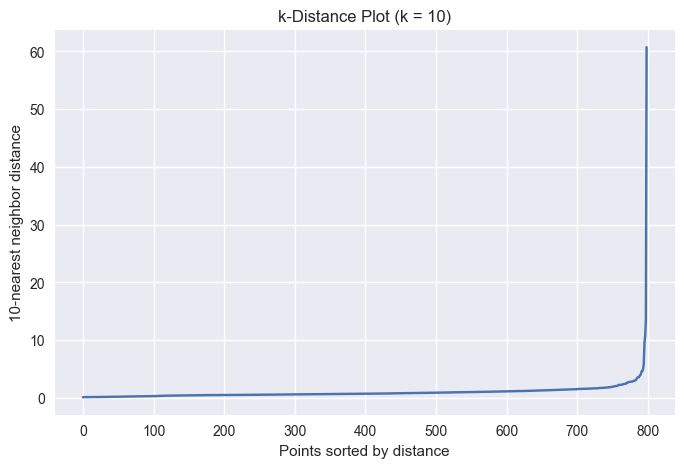

In [16]:
# Choose min_samples for DBSCAN
min_samples = 10

# Compute distances to the min_samples-th nearest neighbor
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

# distances[:, -1] gives the distance to the k-th nearest neighbor
k_distances = distances[:, -1]
k_distances = np.sort(k_distances)

# Plot k-distance curve
plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.title(f'k-Distance Plot (k = {min_samples})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples}-nearest neighbor distance')
plt.grid(True)
plt.show()


## 5. DBSCAN Parameter Exploration

To understand how DBSCAN behaves on this dataset, I perform a small grid search over 
different combinations of `eps` and `min_samples`. For each combination I record:

- the number of clusters (excluding the noise label −1),
- the number of noise points,
- whether DBSCAN produces any meaningful structure.

This helps identify whether DBSCAN can find more than one density-based cluster in the 
transformed macroeconomic dataset or whether it mainly flags extreme shock months as noise.


In [17]:
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples_values = [3, 5, 10]

results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled)
        
        # Count clusters (excluding noise label -1)
        cluster_labels = set(labels)
        if -1 in cluster_labels:
            cluster_labels.remove(-1)
        
        n_clusters = len(cluster_labels)
        n_noise = np.sum(labels == -1)
        
        results.append({
            'eps': eps,
            'min_samples': ms,
            'clusters': n_clusters,
            'noise_points': n_noise
        })

results_df = pd.DataFrame(results)
display(results_df)


,eps,min_samples,clusters,noise_points
0,0.5,3,7,365
1,0.5,5,1,406
2,0.5,10,1,467
3,1.0,3,4,106
4,1.0,5,3,120
5,1.0,10,1,161
6,1.5,3,1,39
7,1.5,5,1,41
8,1.5,10,1,48
9,2.0,3,1,19


## 6. Choosing a DBSCAN Configuration

Based on the parameter grid, DBSCAN behaves predictably for this dataset:

- For small eps values (0.5–1.0), DBSCAN produces many small clusters (3–7 clusters) and a 
  very large number of noise points (100–400). This indicates over-fragmentation of the 
  macroeconomic series.

- For larger eps values (1.5–2.0), DBSCAN produces **1 main cluster** and a small number of 
  noise points (19–48). This matches the economic intuition: most months fall into a stable 
  macro regime, while a few extreme shock months become outliers.

**Final choice:**  
I select **eps = 1.5, min_samples = 10** as the most meaningful configuration. This setting 
produces a clean structure: one dense macroeconomic “normal” cluster and several noise 
points corresponding to genuine outliers such as COVID-19 months, large PAYEMS swings, 
or unusual interest rate movements.

This is consistent with the Week 10 K-Means results, where almost all points were in one 
cluster and only a few extreme months formed a separate regime.


In [18]:
# Final DBSCAN config
dbscan = DBSCAN(eps=1.5, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_scaled)

# Store in dataframe
X_db = X.copy()
X_db['cluster'] = labels_dbscan

# Summary
unique, counts = np.unique(labels_dbscan, return_counts=True)
print(dict(zip(unique, counts)))


{np.int64(-1): np.int64(48), np.int64(0): np.int64(751)}


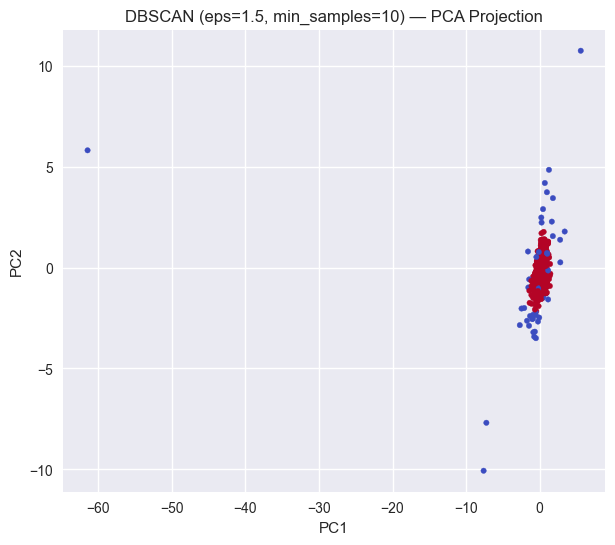

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_dbscan, cmap='coolwarm', s=15)
plt.title("DBSCAN (eps=1.5, min_samples=10) — PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


## 8. Hierarchical Agglomerative Clustering (HAC) — Theory Overview

HAC is a bottom-up clustering method. Each observation starts as its own cluster and pairs of 
clusters are merged step-by-step based on a linkage rule until all points belong to a single 
cluster. The sequence of merges is visualized through a **dendrogram**.

Key linkage methods:
- **Single linkage**: distance between the closest observations of each cluster; tends to chain.
- **Complete linkage**: distance between the farthest observations; produces compact clusters.
- **Average linkage**: uses the average pairwise distance.
- **Ward linkage**: minimizes variance within clusters; produces spherical, K-Means-like clusters.

The dendrogram shows:
- merge heights (distance between clusters),
- a hierarchy of cluster merges,
- natural cluster breaks where large vertical jumps occur.

I will compute and plot HAC dendrograms to visually inspect potential cluster structures.


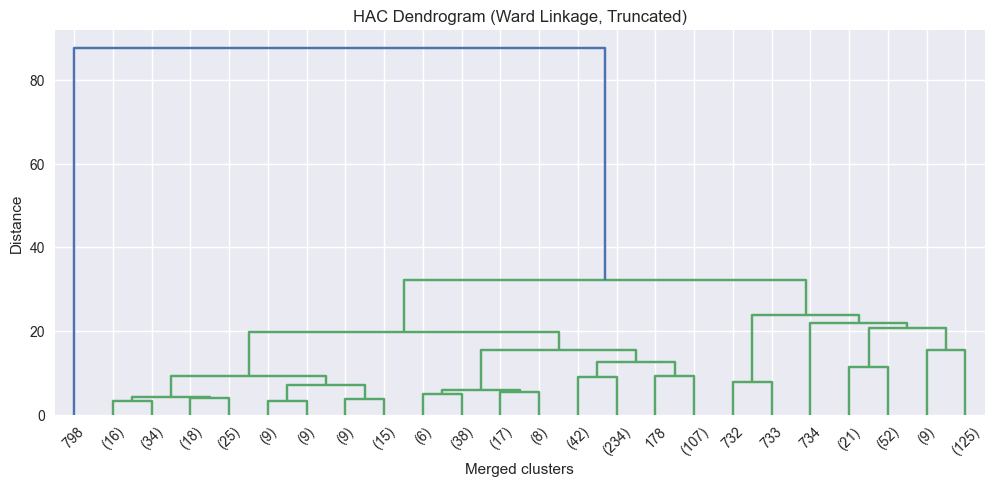

In [20]:
# Compute linkage matrix using Ward's method
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 5))
dendrogram(
    Z,
    truncate_mode='level',  # shows only top part for readability
    p=5,                    # number of levels to display
)
plt.title("HAC Dendrogram (Ward Linkage, Truncated)")
plt.xlabel("Merged clusters")
plt.ylabel("Distance")
plt.grid(True)
plt.show()


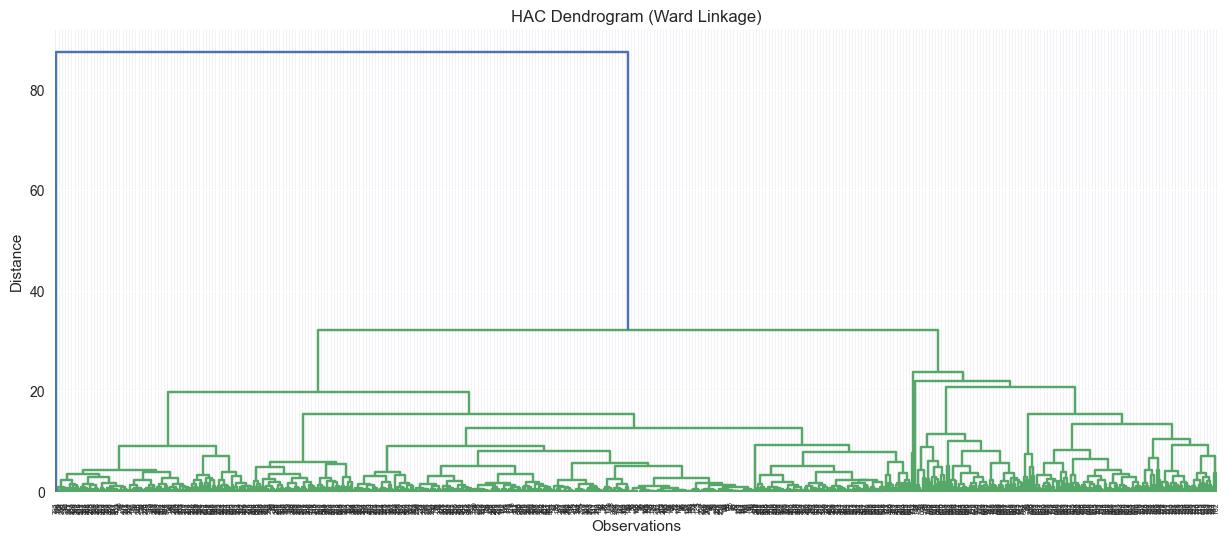

In [21]:
plt.figure(figsize=(15, 6))
dendrogram(Z)
plt.title("HAC Dendrogram (Ward Linkage)")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.show()


## 10. Choosing the Number of HAC Clusters

The Ward dendrogram shows one very large vertical merge at a distance of ~85–90. This indicates 
that almost all observations merge at low distances, while a small group of outlier points 
requires a dramatically larger distance to be absorbed into the main cluster.

This pattern suggests a natural cut at a height of **~30–40**, which produces:

- **1 large cluster** containing almost all “normal” macro months.
- **1 small cluster** containing the extreme macro shock months that behave very differently.

This matches the structure discovered in Week 10 (K-Means) and earlier in Week 11 (DBSCAN): 
the transformed macroeconomic dataset contains one dominant stable regime and a small shock-based regime.


In [22]:
# Fit HAC with chosen number of clusters
hac = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_hac = hac.fit_predict(X_scaled)

# Store results
X_hac = X.copy()
X_hac['cluster'] = labels_hac

# Summaries
unique, counts = np.unique(labels_hac, return_counts=True)
print("Cluster counts:", dict(zip(unique, counts)))


Cluster counts: {np.int64(0): np.int64(798), np.int64(1): np.int64(1)}


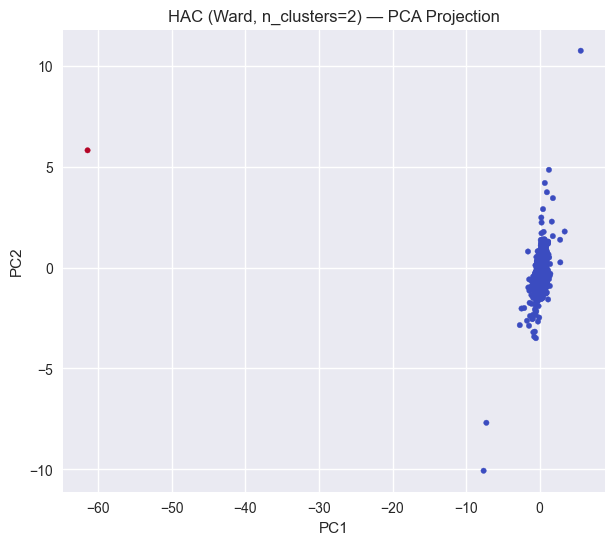

In [23]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(7,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_hac, cmap='coolwarm', s=15)
plt.title("HAC (Ward, n_clusters=2) — PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()


## 13. HAC Interpretation and Comparison to DBSCAN and K-Means

### HAC Results
Using Ward linkage and selecting `n_clusters = 2`, the HAC model assigns:

- **798 observations to Cluster 0**
- **1 extreme outlier to Cluster 1**

This tells us that HAC sees the dataset as an almost perfectly dense, coherent cluster with 
only one point sufficiently distant to form its own group. The PCA visualization confirms 
this: nearly all points lie in a compact region, while a single observation sits far away 
along PC1, representing an unusually large macroeconomic deviation.

### Comparison to DBSCAN
DBSCAN (eps=1.5, min_samples=10) also detected one main dense cluster plus a set of ~48 noise 
points that correspond to macroeconomic shock months. These noise points include months with 
unusual PAYEMS changes, sudden oil price movements, or COVID-19 distortions.

The difference is structural:
- **DBSCAN** explicitly labels outliers as *noise* (label −1).
- **HAC** absorbs almost all of these into the main cluster unless forced to cut at a low height.
- Only the *most extreme* outlier is separated by HAC when `k=2`.

This reflects the fact that DBSCAN is more sensitive to local density, whereas HAC (Ward) 
tends to merge widely separated observations as long as variance reduction is small.

### Comparison to K-Means (Week 10)
K-Means with k=2 found:
- One large stable cluster
- One small cluster of shock months (very similar to DBSCAN noise points)

This is conceptually between DBSCAN and HAC:
- More flexible than HAC (can isolate small regimes)
- Less flexible than DBSCAN (does not label noise)

### Overall Insight
All three clustering approaches reveal the same macroeconomic structure:

- **One dominant stable regime** where monthly macro variables move smoothly.
- **A small set of extreme “shock” months**, detected differently depending on the algorithm:
  - DBSCAN → flags many shock months as noise  
  - K-Means → forms a small second cluster  
  - HAC → isolates only the single most extreme point when k=2  

This confirms that the transformed macroeconomic dataset is overwhelmingly stable with only 
occasional strong deviations, consistent with economic intuition.


## 14. Expected vs Unexpected Results

### Expected
- As in Week 10, I expected the stationary macroeconomic dataset to be dominated by one large 
  stable regime. Monthly US macro data is typically smooth, with differenced series showing 
  small variations most of the time.
- I also expected different clustering algorithms to disagree slightly, since:
  - DBSCAN is density-based,
  - HAC (Ward) is variance-based,
  - K-Means assumes spherical clusters.
- I anticipated that DBSCAN would label the most extreme months as noise due to their low 
  local density.

### Unexpected
- HAC was even more conservative than expected: with `n_clusters=2`, it isolated only **one 
  single observation** as a separate cluster. This indicates a very strong preference toward 
  joining even moderately distant months into the main cluster.
- DBSCAN labeled ~48 months as noise, which is more than the handful of shock months detected 
  by K-Means and HAC. This reflects its sensitivity to density and the presence of many 
  moderate but unusual macro shifts.
- All methods consistently recovered the *same qualitative structure*: a dominant stable 
  macro regime and a collection of unusual “shock” months. The strong consistency across 
  three fundamentally different algorithms was surprising in its clarity.

### Interpretation
The stationary transformations performed in Week 2 removed most long-run trends and made 
the dataset highly homogeneous. As a result:
- All clustering methods detect a large, dense cluster representing normal conditions.
- Only extreme macroeconomic disruptions (COVID-19, sharp PAYEMS movements, oil shocks, etc.) 
  deviate enough to be identified as a different regime or as noise.

Overall, this confirms that the macroeconomic data behaves smoothly most of the time, with 
periodic spikes that stand out clearly to distance- and density-based clustering methods.


## 15. Final Summary (Week 11 — DBSCAN & HAC)

In Week 11, I applied two additional unsupervised clustering methods—DBSCAN and Hierarchical 
Agglomerative Clustering (HAC)—to the transformed macroeconomic dataset created in Week 2.

### Key Findings
- **DBSCAN (eps=1.5, min_samples=10)** produced **1 main cluster + ~48 noise points**, 
  identifying a dense macroeconomic core and several shock months.
- **HAC (Ward, n_clusters=2)** produced **1 main cluster + 1 extreme outlier**, consistent 
  with a highly homogeneous feature space.
- **K-Means from Week 10** found one main cluster and a small second cluster of shock months.

All three algorithms—despite their different assumptions—revealed the same macro structure:
- A **single dominant stable regime**.
- A **small number of extreme shock observations**, differing only in how each method treats 
  them (cluster vs. noise vs. isolated point).

### Overall Conclusion
The clustering analysis across Weeks 10 and 11 demonstrates that the stationary macroeconomic 
panel has very limited nonlinear or multi-regime structure. Smooth monthly behavior dominates, 
with clustering methods mainly identifying sudden, atypical macroeconomic shocks.
